# Persian Stance Classification - Deep Learning

In [ ]:
from tqdm import tqdm
import numpy as np
import pandas as pd
import sys
import datetime
import argparse
import os
import csv
import numpy as np
import os.path as path

# Mount Google Drive

In [ ]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# define path of input files
data_path = "/content/drive/MyDrive/Stance Detection Project/ArticleToClaim.txt"
stopwords_path = "/content/drive/MyDrive/Stance Detection Project/StopWords_fa.txt"
fasttext_path = "/content/drive/MyDrive/Stance Detection Project/cc.fa.300.vec"   # this is a text file

# define path of output files
csv_path = "/content/drive/MyDrive/Stance Detection Project/ArticleToClaim.csv"
cleaned_path = "/content/drive/MyDrive/Stance Detection Project/Clean_Claim_Body.csv"
train_path = "/content/drive/MyDrive/Stance Detection Project/train_data.csv"
test_path = "/content/drive/MyDrive/Stance Detection Project/test_data.csv"
FEATURES_DIR = '/content/drive/MyDrive/Stance Detection Project/features/'
deep_model_path = '/content/drive/MyDrive/persian_stance_deep_data/models/model_v1.h5'

# Prepare Dataset

### Read Dataset from Text File

Claim and Body

1997 samples

748



In [ ]:
# read dataset from text file
import glob

# read text file (ArticleToClaim.txt)
data_file = glob.glob(data_path)
if len(data_file) == 0:
  raise Exception('Data file not found at ' + data_path)

row_documents = []
cnt = 1

for file in data_file:
    with open (file, "r", encoding="utf-8") as fp:
        line = fp.readline() #first line is for the headers (Claim, Body Text, Claim Is Question, Claim Has Tow Parts, Stance)
        content = fp.read() #read the rest of the file to a string

row_documents = content.split("#@@@@@#") #split the instances by the custom delimiter
row_documents = list(filter(None, row_documents)) #remove empty instance
print("number of samples : ", len(row_documents))

number of samples :  1997


### Write Dataset to CSV File

In [ ]:
print('converting text data to csv file..')
claim = []
body = []
question = []
part = []
headline = []
label = []    
index = []
i = 0
row_doc = np.asarray(row_documents)
for row in row_doc:
    claim.append(row.split(',')[0])
    body.append(row.split(',')[1])
    question.append(row.split(',')[2])
    part.append(row.split(',')[3])
    headline.append(row.split(',')[4])
    label.append(row.split(',')[-1])
    index.append(i)
    i += 1
    
Dataset = list(zip(index, claim, body, question, part, headline, label))
print(Dataset[0])

converting text data to csv file..
(0, 'مسمومیت زا بودن شدید قارچهای خودرو (وحشی) مشابه قارچهای موجود در بازار !', 'به گزارش اقتصادآنلاین به نقل از تسنیم، رخداد مسمومیت قارچی بهار 97؛ حادثه\u200cهای مرگباری بود که نه از طریق تصادف یا سقوط و یا غرق شدگی - برای مسافران و گردشگران رخ داده باشد؛ بلکه در رویدادی کم تکرار - علت این مرگ\u200cها قارچ بوده است! بطوریکه تا  غروب دوشنبه 31 اردیبهشت 1017 نفر به بیمارستان\u200cها مراجعه کردند که از این تعداد 116 نفر در بیمارستان بستری شدند و متأسفانه 15 نفر جان خود را از دست دادند.\n\nدر این زمینه برای واکاوی بیشتر این رویداد تلخ و تاسف بار که می\u200cطلبید برخی نهادهای مسؤل در حوزه طبیعت از جمله سازمان محیط زیست و .... قبل از وقوع این حوادث که به زعم کارشناسان امر یکی از دلایل مهم آن بارندگی زیاد و رویش این قارچ\u200cها بود، مردم نسبت به استفاده نکردن خوراکی این قارچ\u200cها حداقل از نظر آگاهی رسانی مطلع و به آنان هشدار داده می\u200cشد.', '0', '0', 'Discuss', 'Discuss')


In [ ]:
df = pd.DataFrame(data = Dataset, columns=['index', 'claim', 'body', 'question', 'part', 'headline', 'label'])
df.to_csv(csv_path, index=False, encoding="utf-8")

print('done!')

done!


### Read Dataset from CSV File

In [ ]:
dataset = pd.read_csv(csv_path, index_col = 0)

In [ ]:
dataset = dataset.sort_index()

In [ ]:
dataset.columns

Index(['claim', 'body', 'question', 'part', 'headline', 'label'], dtype='object')

In [ ]:
claim = dataset['claim']
headline = dataset['headline']
body = dataset['body']
label = dataset['label']

In [ ]:
len(body)

1997

In [ ]:
print(claim[0], "\n", body[0], "\n", label[0])

مسمومیت زا بودن شدید قارچهای خودرو (وحشی) مشابه قارچهای موجود در بازار ! 
 به گزارش اقتصادآنلاین به نقل از تسنیم، رخداد مسمومیت قارچی بهار 97؛ حادثه‌های مرگباری بود که نه از طریق تصادف یا سقوط و یا غرق شدگی - برای مسافران و گردشگران رخ داده باشد؛ بلکه در رویدادی کم تکرار - علت این مرگ‌ها قارچ بوده است! بطوریکه تا  غروب دوشنبه 31 اردیبهشت 1017 نفر به بیمارستان‌ها مراجعه کردند که از این تعداد 116 نفر در بیمارستان بستری شدند و متأسفانه 15 نفر جان خود را از دست دادند.

در این زمینه برای واکاوی بیشتر این رویداد تلخ و تاسف بار که می‌طلبید برخی نهادهای مسؤل در حوزه طبیعت از جمله سازمان محیط زیست و .... قبل از وقوع این حوادث که به زعم کارشناسان امر یکی از دلایل مهم آن بارندگی زیاد و رویش این قارچ‌ها بود، مردم نسبت به استفاده نکردن خوراکی این قارچ‌ها حداقل از نظر آگاهی رسانی مطلع و به آنان هشدار داده می‌شد. 
 Discuss


### Data Analyzes

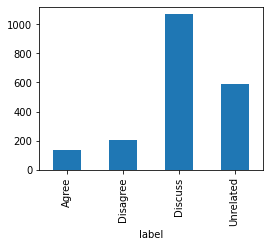

In [ ]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(4,3))
dataset.groupby('label').headline.count().plot.bar(ylim=0)
plt.show()

In [ ]:
dataset.groupby('label').headline.count()

label
Agree         137
Disagree      206
Discuss      1068
Unrelated     586
Name: headline, dtype: int64

In [ ]:
len(dataset)

1997

In [ ]:
dataset.groupby('label').headline.count() * 100/len(dataset)

label
Agree         6.860290
Disagree     10.315473
Discuss      53.480220
Unrelated    29.344016
Name: headline, dtype: float64

# Clean Data

### Clean Data by Hazm Library

In [ ]:
!pip install hazm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 316 kB 5.1 MB/s 
     |████████████████████████████████| 233 kB 44.7 MB/s 
     |████████████████████████████████| 1.4 MB 49.8 MB/s 
  Created wheel for nltk: filename=nltk-3.3-py3-none-any.whl size=1394488 sha256=c486fc981f5c45ea23d7730c46279f9020aad15a8719266be2b9794385001b1b
  Stored in directory: /root/.cache/pip/wheels/9b/fd/0c/d92302c876e5de87ebd7fc0979d82edb93e2d8d768bf71fac4
  Created wheel for libwapiti: filename=libwapiti-0.2.1-cp37-cp37m-linux_x86_64.whl size=154754 sha256=ba258ee6ffa72a7d1cee46988cdb7f411c73eb1c7bc7ee7d2d788dd0a7fff529
  Stored in directory: /root/.cache/pip/wheels/ab/b2/5b/0fe4b8f5c0e65341e8ea7bb3f4a6ebabfe8b1ac31322392dbf
Successfully built nltk libwapiti
  Attempting uninstall: nltk
    Found existing installation: nltk 3.7
    Uninstalling nltk-3.7:
      Successfully uninstalled nltk-3.7


In [ ]:
try:
    from hazm import *
    print('hazm is already installed')
except ImportError as e:
    raise Exception('hazm is not installed')

# installation command:
# !pip install hazm

hazm is already installed


In [ ]:
from __future__ import unicode_literals
from hazm import *

In [ ]:
 
k = []
with open(stopwords_path, 'r', encoding="utf-8") as f:
    for word in f:
        word = word.split('\n')
        k.append(word[0])
        
def remove_stopwords(text):
    sw_data = []
    for i in text:
        for j in k:
            if j in word_tokenize(i):
                i.replace(j, '')
        sw_data.append(i)
    return sw_data


def remove_slash(text):
    ext_data = []
    for i in text:
        if '/' in i:
            spl = i.split('/')
            if 'شایعه' in spl[-1]:
                i = i.replace(spl[-1], '')
        ext_data.append(i)
    return ext_data


import re
r = re.compile("[\!\;,؟:?،؛.+»«<>|\#(\)\-\/\'\"]")
def remove_punc(text):
    punc = []
    for i in text:
        punc.append(r.sub("", i))
    return punc

extra_str = ['\u200c', '\u200d', '\u200e', '\u200b', '\r', '\n', '\ufeff']
def clean_data(text):
    
    print("start cleaning data..")
    
    text = remove_slash(text)
    
    clean_data = []
    for i in text:
        for j in extra_str:
            if j in i:
                i = i.replace(j,'')
        clean_data.append(i)
    
    print("data is ready!")
    return clean_data

In [ ]:
import re
r = re.compile("[\!\;,؟:?،؛.+»«<>|\#(\)\-\/\'\"]")
def clean(text):
    return r.sub("", text)

In [ ]:
clean_claim = clean_data(claim)

start cleaning data..
data is ready!


In [ ]:
clean_body = clean_data(body)

start cleaning data..
data is ready!


In [ ]:
clean_body[0]

'به گزارش اقتصادآنلاین به نقل از تسنیم، رخداد مسمومیت قارچی بهار 97؛ حادثههای مرگباری بود که نه از طریق تصادف یا سقوط و یا غرق شدگی - برای مسافران و گردشگران رخ داده باشد؛ بلکه در رویدادی کم تکرار - علت این مرگها قارچ بوده است! بطوریکه تا  غروب دوشنبه 31 اردیبهشت 1017 نفر به بیمارستانها مراجعه کردند که از این تعداد 116 نفر در بیمارستان بستری شدند و متأسفانه 15 نفر جان خود را از دست دادند.در این زمینه برای واکاوی بیشتر این رویداد تلخ و تاسف بار که میطلبید برخی نهادهای مسؤل در حوزه طبیعت از جمله سازمان محیط زیست و .... قبل از وقوع این حوادث که به زعم کارشناسان امر یکی از دلایل مهم آن بارندگی زیاد و رویش این قارچها بود، مردم نسبت به استفاده نکردن خوراکی این قارچها حداقل از نظر آگاهی رسانی مطلع و به آنان هشدار داده میشد.'

### Write Cleaned Data to CSV File

In [ ]:
Dataset = list(zip(clean_claim, clean_body, label))
np.random.shuffle(Dataset)  
df = pd.DataFrame(data = Dataset, columns=['claim', 'body', 'label'])
df.to_csv(cleaned_path, index=True, encoding="utf-8")

print('save clean data.')

save clean data.


### Read Cleaned Data from CSV File

In [ ]:
import pandas as pd
dataset_clean = pd.read_csv(cleaned_path, index_col = 0, )

In [ ]:
clean_claim = dataset_clean['claim']
clean_body = dataset_clean['body']

In [ ]:
dataset_clean.head()

,claim,body,label
0,بازی عجیب نماینده چابهار در مجلس با میکروفون !,به گزارش ایسنا- عبدالغفور ایران نژاد افزود: 10...,Unrelated
1,مسمومیت زا بودن شدید قارچهای خودرو (وحشی) مشاب...,سخنگوی اورژانس کشور در گفت و گو با خبرنگار گرو...,Discuss
2,تذکر عباسپور در لحظه قهرمانی به یک دختر، برای ...,به گزارش سایت فدراسیون بدنسازی و پرورش اندام، ...,Unrelated
3,تخریب تندیس شهریار در پارسآباد اردبیل !,به گزارش آران مغان، این تندیس که 10 فروردين ما...,Agree
4,ساخت میدانی به نام صدام، پاسخ کمک های ایران به...,به گزارش«شیعه نیوز»، سرلشکر رافع رواجبه استاند...,Discuss


#Split Data

### Split Dataset into Train and Test sets

In [ ]:
from sklearn.model_selection import train_test_split

y = dataset_clean.label
X = dataset_clean.drop('label', axis=1)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

### Save Data Train to CSV File

In [ ]:
# Data_train = list(zip(X_train['claim'], X_train['body'], y_train))
    
# df = pd.DataFrame(data = Data_train, columns=['claim', 'body', 'label'])
# df.to_csv(train_path, index=True, encoding="utf-8")

# print('save train data.')

### Save Data Test to CSV File

In [ ]:
# Data_test = list(zip(X_test['claim'], X_test['body'], y_test))
    
# df = pd.DataFrame(data = Data_test, columns=['claim', 'body', 'label'])
# df.to_csv(test_path, index=True, encoding="utf-8")

# print('save test data.')

### Read Data Train and Test from CSV Files

In [ ]:
data_train = pd.read_csv(train_path, index_col = 0, )
data_test = pd.read_csv(test_path, index_col = 0, )

In [ ]:
len(data_train), len(data_test)

(1597, 400)

# Extract Feature

### BOW Feature Extractor

In [ ]:
def ngrams(input, n):
    input = input.split(' ')
    output = []
    for i in range(len(input) - n + 1):
        output.append(input[i:i + n])
    return output


def chargrams(input, n):
    output = []
    for i in range(len(input) - n + 1):
        output.append(input[i:i + n])
    return output


def append_chargrams(features, text_headline, text_body, size):
    grams = [' '.join(x) for x in chargrams(" ".join(remove_stopwords(text_headline.split())), size)]
    grams_hits = 0
    grams_early_hits = 0
    grams_first_hits = 0
    for gram in grams:
        if gram in text_body:
            grams_hits += 1
        if gram in text_body[:255]:
            grams_early_hits += 1
        if gram in text_body[:100]:
            grams_first_hits += 1
    features.append(grams_hits)
    features.append(grams_early_hits)
    features.append(grams_first_hits)
    return features


def append_ngrams(features, text_headline, text_body, size):
    grams = [' '.join(x) for x in ngrams(text_headline, size)]
    grams_hits = 0
    grams_early_hits = 0
    for gram in grams:
        if gram in text_body:
            grams_hits += 1
        if gram in text_body[:255]:
            grams_early_hits += 1
    features.append(grams_hits)
    features.append(grams_early_hits)
    return features


def hand_features(headlines, bodies):

    def binary_co_occurence(headline, body):
        # Count how many times a token in the title
        # appears in the body text.
        bin_count = 0
        bin_count_early = 0
        for headline_token in clean(headline).split(" "):
            if headline_token in clean(body):
                bin_count += 1
            if headline_token in clean(body)[:255]:
                bin_count_early += 1
        return [bin_count, bin_count_early]

    def binary_co_occurence_stops(headline, body):
        # Count how many times a token in the title
        # appears in the body text. Stopwords in the title
        # are ignored.
        bin_count = 0
        bin_count_early = 0
        for headline_token in remove_stopwords(clean(headline).split(" ")):
            if headline_token in clean(body):
                bin_count += 1
                bin_count_early += 1
        return [bin_count, bin_count_early]

    def count_grams(headline, body):
        # Count how many times an n-gram of the title
        # appears in the entire body, and intro paragraph

        clean_body = clean(body)
        clean_headline = clean(headline)
        features = []
        features = append_chargrams(features, clean_headline, clean_body, 2)
        features = append_chargrams(features, clean_headline, clean_body, 8)
        features = append_chargrams(features, clean_headline, clean_body, 4)
        features = append_chargrams(features, clean_headline, clean_body, 16)
        features = append_ngrams(features, clean_headline, clean_body, 2)
        features = append_ngrams(features, clean_headline, clean_body, 3)
        features = append_ngrams(features, clean_headline, clean_body, 4)
        features = append_ngrams(features, clean_headline, clean_body, 5)
        features = append_ngrams(features, clean_headline, clean_body, 6)
        return features

    X = []
    for i, (headline, body) in tqdm(enumerate(zip(headlines, bodies))):
        X.append(binary_co_occurence(headline, body)
                 + binary_co_occurence_stops(headline, body)
                 + count_grams(headline, body))
    return X
# ------------------------------------------------------------------------------

from sklearn.feature_extraction.text import TfidfVectorizer

def char_3grams_5000_concat_all_data(headlines, bodies):

    def combine_head_and_body(headlines, bodies):
        return [headline + " " + body for i, (headline, body) in
                tqdm(enumerate(zip(headlines, bodies)))]

    # Load train data into CountVectorizer, get the resulting X-values and also the vocabulary
    # for the test data feature creation
    def get_features(headlines, bodies, headlines_all, bodies_all):
        # create vocab on basis of training data
        head_and_body = combine_head_and_body(headlines_all, bodies_all)
        head_and_body_tfidf = TfidfVectorizer(analyzer='char', ngram_range=(3, 3), lowercase=True,
                                              max_features=5000, use_idf=False, norm='l2')
        head_and_body_tfidf.fit(head_and_body)
        vocab = head_and_body_tfidf.vocabulary_

        # create training feature vectors
        X_train_head_tfidf = TfidfVectorizer(analyzer='char', ngram_range=(3, 3), lowercase=True,
                                             stop_words='english', vocabulary=vocab, use_idf=False, norm='l2')
        X_train_head = X_train_head_tfidf.fit_transform(headlines)

        X_train_body_tfidf = TfidfVectorizer(analyzer='char', ngram_range=(3, 3), lowercase=True,
                                             stop_words='english', vocabulary=vocab, use_idf=False, norm='l2')
        X_train_body = X_train_body_tfidf.fit_transform(bodies)

        X_train = np.concatenate([X_train_head.toarray(), X_train_body.toarray()], axis=1)

        return X_train

    h, b = data_train['claim'].tolist() , data_train['body'].tolist()
    h_test, b_test = data_test['claim'].tolist(), data_test['body'].tolist()

    # Comment out for clean ablation tests
    h.extend(h_test)
    b.extend(b_test)

    X_train = get_features(headlines, bodies, h, b)

    return X_train
# ------------------------------------------------------------------------------

# test this feature extractor function before final feature extraction step
x = char_3grams_5000_concat_all_data(clean_claim, clean_body)
# ------------------------------------------------------------------------------
print(x.shape)

1997it [00:00, 228391.37it/s]


### Negated Context Feature Extractor

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

# this function takes a very long time to finish execution!
def negated_context_word_12grams_concat_tf5000_l2_all_data(headlines, bodies):
    """
    Negates string after special negation word by adding a "NEG_" in front
    of every negated word, until a punctuation mark appears.
    Source:
        NRC-Canada: Buidling the State-of-the-Art in Sentiment Analysis of Tweets
        http://sentiment.christopherpotts.net/lingstruc.html
        http://stackoverflow.com/questions/23384351/how-to-add-tags-to-negated-words-in-strings-that-follow-not-no-and-never


    :param headlines:
    :param bodies:
    :return:
    """
    def get_negated_text(text):
      sens = text.replace(';','.').replace(',','.').replace('!','.').replace(':','.').replace('،', '').split('.')
      li_1 = ['هیچ', 'اصلا', 'هیچگونه']
      li_2 = [ 'ندارد', 'نمیتواند']
      jomles = []
      for sen in sens: 
        first, second = 0 , 0
        flag_1, flag_2 = False, False
        tokens = word_tokenize(sen)
        jomle = []    
        for i in range(len(tokens)):
          if tokens[i] in li_1 and flag_1 == False:
            first = i
            flag_1 = True
          if tokens[i] in li_2 and flag_2 == False:
            second = i
            flag_2 = True
        if (second > first) and (flag_1 == True) and (flag_2 == True):
          for j in range (first + 1 , second-1 ):
            sen = sen.replace(tokens[j], 'NEG_'+tokens[j])
        jomles.append(sen)
    
      jomles = '. '.join(jomles)
  
      return jomles

    def combine_head_and_body(headlines, bodies):
        head_and_body = [headline + " " + body for i, (headline, body) in
                         enumerate(zip(headlines, bodies))]

        return head_and_body

    def get_vocab(neg_headlines, neg_bodies):
        neg_headlines = remove_stopwords(neg_headlines)
        neg_bodies = remove_stopwords(neg_bodies)
        tf_vectorizer = TfidfVectorizer(ngram_range=(1, 2), max_features=5000, use_idf=False,
                                        norm='l2')
        tf_vectorizer.fit_transform(combine_head_and_body(neg_headlines, neg_bodies))
        vocab = tf_vectorizer.vocabulary_

        return vocab

    def get_features(neg_headlines_test, neg_bodies_test, vocab):
        neg_headlines_test = remove_stopwords(neg_headlines_test)
        neg_bodies_test = remove_stopwords(neg_bodies_test)
        
        tf_vectorizer_head = TfidfVectorizer(vocabulary=vocab, use_idf=False, norm='l2')
        X_test_head = tf_vectorizer_head.fit_transform(neg_headlines_test)

        tf_vectorizer_body = TfidfVectorizer(vocabulary=vocab, use_idf=False, norm='l2')
        X_test_body = tf_vectorizer_body.fit_transform(neg_bodies_test)

        X_test = np.concatenate([X_test_head.toarray(), X_test_body.toarray()], axis=1)
        return X_test

#     h, b = get_head_body_tuples(include_holdout=True)
#     h_test, b_test = get_head_body_tuples_test()
    
    h, b = data_train['claim'].tolist() , data_train['body'].tolist()
    h_test, b_test = data_test['claim'].tolist(), data_test['body'].tolist()

    # Comment out for clean ablation tests
    h.extend(h_test)
    b.extend(b_test)

    neg_headlines_all = [get_negated_text(h) for h in h]
    neg_bodies_all = [get_negated_text(b) for b in b]
    neg_headlines = [get_negated_text(h) for h in headlines]
    neg_bodies = [get_negated_text(b) for b in bodies]

    vocab = get_vocab(neg_headlines_all, neg_bodies_all)
    X_train = get_features(neg_headlines, neg_bodies, vocab)

    return X_train

In [ ]:
# x = negated_context_word_12grams_concat_tf5000_l2_all_data(clean_claim, clean_body)
# this line is commented in the main notebook

### Create Word Embedding Matrix

#### Download Fasttext Word Vectors File

In [ ]:
# download fasttext word vectors for persian (text file version)
# !wget https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.fa.300.vec.gz 
# ------------------------------------------------------------------------------
# unzip fasttext word vectors for persian
# !gunzip cc.fa.300.vec.gz

# then copy unziped text file to you google drive for future use

#### Load Embedding Matrix

In [ ]:
def load_embedding_pandas(FILE, type="w2v"):
  embeddings_index=dict()
  f = open(FILE)
  for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
  f.close()
  print('Loaded %s word vectors.' % len(embeddings_index))
  return embeddings_index

# ------------------------------------------------------------------------------

GloVe_vectors = load_embedding_pandas(fasttext_path)
# takes a little time...don't worry!

# ------------------------------------------------------------------------------

g_vec = pd.DataFrame.from_dict(GloVe_vectors)
# takes a little time...don't worry!

In [ ]:
# print a sample word-vector
g_vec.iloc[:,200]

#### Remve feature for get better f1

In [ ]:
# char_3grams_5000_concat_all_data = FEATURES_DIR+'char_3grams_5000_concat_all_data.first_1.npy';
# hand = FEATURES_DIR+'hand.first_1.npy';
# negated_context_word_12grams_concat_tf5000_l2_all_data = FEATURES_DIR+'negated_context_word_12grams_concat_tf5000_l2_all_data.first_1.npy';
# single_flat_LSTM_50d_100_embedding = FEATURES_DIR+'single_flat_LSTM_50d_100_embedding.npy';
# single_flat_LSTM_50d_100_param_dict = FEATURES_DIR+'single_flat_LSTM_50d_100_param_dict.pkl';
# single_flat_LSTM_50d_100_vocab = FEATURES_DIR+'single_flat_LSTM_50d_100_vocab.pkl';
# single_flat_LSTM_50d_100 = FEATURES_DIR+'single_flat_LSTM_50d_100.first_1.npy';

# try:
#   if char_3grams_5000_concat_all_data:
#     os.remove(char_3grams_5000_concat_all_data)
#   if hand:
#     os.remove(hand)
#   if negated_context_word_12grams_concat_tf5000_l2_all_data:
#     os.remove(negated_context_word_12grams_concat_tf5000_l2_all_data)
#   if single_flat_LSTM_50d_100_embedding:
#     os.remove(single_flat_LSTM_50d_100_embedding)
#   if single_flat_LSTM_50d_100_param_dict:
#     os.remove(single_flat_LSTM_50d_100_param_dict)
#   if single_flat_LSTM_50d_100_vocab:
#     os.remove(single_flat_LSTM_50d_100_vocab)
#   if single_flat_LSTM_50d_100:
#     os.remove(single_flat_LSTM_50d_100)
# except:
#   print("...")


#### Reduction of FastText from 300 to 50 Dimension Vectors

In [ ]:
import pickle
import nltk

def create_embedding_lookup_pandas(text_list, max_nb_words, embedding_dim, embedding,
                            embedding_lookup_name, embedding_vocab_name, rdm_emb_init=False, add_unknown=False, tokenizer=None, init_zeros = False):
    """
    Creates the claim embedding lookup table if it not already exists and returns the vocabulary for it
    :param text_list:
    :param max_nb_words:
    :param embedding_dim:
    :param GloVe_vectors:
    :param embedding_lookup_name:
    :param embedding_vocab_name:
    :return:
    """
    #del GloVe_vectors

    # if ...embedding.npy or vocab.pkl files don't exist: 
    if not path.exists(FEATURES_DIR + embedding_lookup_name) or not path.exists(FEATURES_DIR + embedding_vocab_name):
        print("can't find npy or pkl file!")
        vectorizer = TfidfVectorizer(ngram_range=(1, 1), stop_words=None, tokenizer=tokenizer,
                                            max_features=max_nb_words, use_idf=True)
        vectorizer.fit_transform(text_list)
        vocab = vectorizer.vocabulary_


        # do not use 0 since we want to use masking in the LSTM later on
        for word in vocab.keys():
            vocab[word] += 1
        if add_unknown == True:
            max_index = max(vocab.values())
            vocab["UNKNOWN"] = max_index+1

        # prepare embedding - create matrix that holds the glove vector for each vocab entry
        if rdm_emb_init == True:
            embedding_lookup = np.random.random((len(vocab) + 1, embedding_dim))
            zero_vec = np.zeros((embedding_dim))
            embedding_lookup[0] = zero_vec # for masking
        else:
            embedding_lookup = np.zeros((len(vocab) + 1, embedding_dim))

        if init_zeros == False:
            for word, i in vocab.items():
                if word == "UNKNOWN":
                    embedding_vector = np.random.uniform(low=-0.05, high=0.05, size=embedding_dim)
                    #print(embedding_vector)
                else:
                    try:
                        embedding_vector = embedding.loc[word].as_matrix()
                    except KeyError: #https://stackoverflow.com/questions/15653966/ignore-keyerror-and-continue-program
                        continue
                if embedding_vector is not None:
                    # words not found in embedding index will be all-zeros.
                    embedding_lookup[i] = embedding_vector
        print("created embedding lookup!")
        #print(embedding_lookup[-1])
        # save embedding matrix
        np.save(FEATURES_DIR + embedding_lookup_name, embedding_lookup)
        print("embedding matrix saved!")
        # save vocab
        with open(FEATURES_DIR + embedding_vocab_name, 'wb') as f:
            pickle.dump(vocab, f, pickle.HIGHEST_PROTOCOL)
        print("vocab saved!")

        print("Embedding lookup table shape for " + embedding_lookup_name + " is: " + str(embedding_lookup.shape))
    #if both .npy and .pkl files exist:
    else:
        print("found npy and pkl files!")
        with open(FEATURES_DIR + embedding_vocab_name, "rb") as f:
            vocab = pickle.load(f)

    print("Vocab size for " + embedding_vocab_name + " is: " + str(len(vocab)))

    return vocab

# ------------------------------------------------------------------------------

nltk.download('punkt')

# ------------------------------------------------------------------------------

def text_to_sequences_fixed_size(texts, vocab, MAX_SENT_LENGTH, save_full_text=False, take_full_claim = False):
    """
    Turns sentences of claims into sequences of indices provided by the given vocab.
    Unknown words will get an extra index, if
    the vocab has a token "UNKNOWN". The method takes the longest sentence of the claims, if the
    claim should have more than one sentence.
    :param texts:
    :param vocab:
    :param MAX_SENT_LENGTH:
    :return:
    """
    data = np.zeros((len(texts), MAX_SENT_LENGTH), dtype='int32')

    claims = []
    if take_full_claim == False:
        for claim in texts:
            claim_sents = nltk.sent_tokenize(claim)
            word_count_fct = lambda sentence: len(nltk.word_tokenize(sentence)) # take longest sentence of claim if it has more than one
            claims.append(max(claim_sents, key=word_count_fct))
    else:
        claims = texts

    data_string_dict = {}
    for j, claim in tqdm(enumerate(claims)):
        claim_tokens = nltk.word_tokenize(claim.lower())

        data_string = ""
        if save_full_text == True:
            for token in claim_tokens:
                data_string += token + " "
            data_string = data_string[:-1]
            data_string_dict[j] = data_string

        for i, token in enumerate(claim_tokens):
            if i < MAX_SENT_LENGTH:
                index = vocab.get(token, "UNKNOWN")
                if index == "UNKNOWN":
                    index = vocab.get(index, None)
                if index != None:
                    data[j, i] = index

    if save_full_text == True:
        return data, data_string_dict
    else:
        return data

# ------------------------------------------------------------------------------

def single_flat_LSTM_50d_100(headlines, bodies, GloVe_vectors):

    #########################
    # PARAMETER DEFINITIONS #
    #########################
    method_name = "single_flat_LSTM_50d_100"
    # location path for features
    PARAM_DICT_FILENAME = method_name+"_param_dict.pkl"

    param_dict = {
        "MAX_NB_WORDS": 50000,  # size of the vocabulary

        # sequence lengths
        "MAX_SEQ_LENGTH": 100, #1000

        # embedding specific values
        "EMBEDDING_DIM": 50,  # dimension of the GloVe embeddings
        #"GLOVE_ZIP_FILE": "/content/drive/My Drive/persian_stance_baseline_data/vectors/cc.fa.300.vec.gz",  #*********************
        #"GLOVE_FILE": "/content/drive/My Drive/persian_stance_baseline_data/vectors/cc.fa.300.vec",  #*********************

        # embedding file names
        "EMBEDDING_FILE": method_name+"_embedding.npy",

        # vocab file names
        "VOCAB_FILE": method_name+"_vocab.pkl",
    }


    ###############################################
    # GET VOCABULARY AND PREPARE EMBEDDING MATRIX #
    ###############################################

    # load GloVe embeddings
    # load the whole embedding into memory
    
#     GloVe_vectors = load_embedding_pandas(param_dict["GLOVE_FILE"])
    

    # load all claims, orig_docs and evidences
    all_heads, all_bodies = data_train['claim'].tolist() , data_train['body'].tolist()
    all = all_heads
    all.extend(all_bodies)
   
    

    # Comment out for clean ablation checks
    # add the unlabeled test data words to the BoW of test+train+holdout data
    h_unlbled_test, b_unlbled_test = data_test['claim'].tolist(), data_test['body'].tolist()
    all.extend(h_unlbled_test)
    all.extend(b_unlbled_test)
    

    # create and save the embedding matrices for claims, orig_docs and evidences
    vocab = create_embedding_lookup_pandas(all, param_dict["MAX_NB_WORDS"], param_dict["EMBEDDING_DIM"],
                                           GloVe_vectors, param_dict["EMBEDDING_FILE"], param_dict["VOCAB_FILE"], init_zeros=False,
                                           add_unknown=True, rdm_emb_init=True, tokenizer=nltk.word_tokenize)

    # unload GloVe_vectors in order to make debugging possible
    del GloVe_vectors


    #################################################
    # Create sequences and embedding for the claims #
    #################################################
    print("Create sequences and embedding for the heads")

    concatenated = []
    for i in range(len(headlines)):
        concatenated.append(headlines[i] + ". " + bodies[i])

    # replace tokens of claims by vocabulary ids - the ids refer to the index of the embedding matrix which holds the word embedding for this vocab word
    sequences = text_to_sequences_fixed_size(concatenated, vocab, param_dict["MAX_SEQ_LENGTH"], save_full_text=False,
                                             take_full_claim=True)



    #################################################
    # SAVE PARAM_DICT AND CONCATENATE TRAINING DATA #
    #################################################

    # save param_dict
    with open(FEATURES_DIR+PARAM_DICT_FILENAME, 'wb') as f:
        pickle.dump(param_dict, f, pickle.HIGHEST_PROTOCOL)
    print("Save PARAM_DICT as " + FEATURES_DIR+PARAM_DICT_FILENAME)

    return sequences

In [ ]:
# Reduction of Glove Word Embedding Model to Dimension of 50 instead of 300
# Generated File is Saved to Features Directory of the Project
# This File is Later Used by Feature Extraction Function
aa = single_flat_LSTM_50d_100(clean_claim, clean_body, g_vec)   # dimension of vectors: 50, max sequence length: 100

# Generate Features

In [ ]:
dataset_clean.columns

In [ ]:
bow_feats = ['hand', 'negated_context_word_12grams_concat_tf5000_l2_all_data', 'char_3grams_5000_concat_all_data']

word_emb = ['single_flat_LSTM_50d_100']

#topic_models = ['latent_dirichlet_allocation_300', 'latent_semantic_indexing_gensim_300_concat', 'NMF_fit_all_concat_300_no_holdout', 'NMF_cos_300']
# topic_models = ['latent_dirichlet_allocation_300', 'latent_semantic_indexing_gensim_300_concat_holdout', 'NMF_fit_all_concat_300_and_test', 'NMF_cos_300']

In [ ]:
def gen_or_load_feats(feat_fn, headlines, bodies, feature_file, feature):
    if not os.path.isfile(feature_file):
        if 'single_flat_LSTM_50d_100' in feature:
            feats = feat_fn(headlines, bodies, g_vec)
        else:
            feats = feat_fn(headlines, bodies)
        np.save(feature_file, feats)

    return np.load(feature_file)

In [ ]:
def generate_features(dataset, name, feature_list, features_dir):
    """
    Creates feature vectors out of the provided dataset
    """
    h, b, y = [], [], []

    feature_dict = {'hand': hand_features,
                    'single_flat_LSTM_50d_100': single_flat_LSTM_50d_100,
                    'char_3grams_5000_concat_all_data': char_3grams_5000_concat_all_data,
                    'negated_context_word_12grams_concat_tf5000_l2_all_data': negated_context_word_12grams_concat_tf5000_l2_all_data,
                    }
    
    y = dataset['label'].tolist()
    h = dataset['claim'].tolist()
    b = dataset['body'].tolist()

    X_feat = []
    feat_list = []
    last_index = 0
    for feature in feature_list:
        print("processing " + feature)
        feat = gen_or_load_feats(feature_dict[feature], h, b, features_dir+"/"+feature+"."+name+'.npy', feature)
        feat_list.append((last_index, last_index+len(feat[0]), str(feature)))
        last_index += len(feat[0])
        X_feat.append(feat)
    print("done with processing all features in feature_list")
    X = np.concatenate(X_feat, axis=1)

    return X, y, feat_list

In [ ]:
feature_list = word_emb + bow_feats
name = 'first_1'

In [ ]:
feature_list

In [ ]:
X, y , feature_list = generate_features(dataset_clean, name, feature_list, FEATURES_DIR)
# this code takes a very very long time to finish execution if the files required are not generated before...don't worry!

In [ ]:
feature_list

# Base line (Majority Voting)

majority vote

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    dataset_clean['claim'], dataset_clean['label'], test_size=0.2, random_state=42)

In [ ]:
from sklearn.dummy import DummyClassifier

clf_maj = DummyClassifier(strategy="most_frequent")

clf_maj.fit(X_train, y_train)

y_pred_maj = clf_maj.predict(X_test)

In [ ]:
LABELS = ['Agree', 'Disagree', 'Discuss', 'Unrelated']
LABELS_RELATED = ['unrelated','related']
RELATED = LABELS[0:3]

def score_submission(gold_labels, test_labels):
    score = 0.0
    cm = [[0, 0, 0, 0],
          [0, 0, 0, 0],
          [0, 0, 0, 0],
          [0, 0, 0, 0]]

    for i, (g, t) in enumerate(zip(gold_labels, test_labels)):
        g_stance, t_stance = g, t
        if g_stance == t_stance:
            score += 0.25
            if g_stance != 'unrelated':
                score += 0.50
        if g_stance in RELATED and t_stance in RELATED:
            score += 0.25

        cm[LABELS.index(g_stance)][LABELS.index(t_stance)] += 1

    return score, cm

In [ ]:
score, cm = score_submission(y_test, y_pred_maj)
fold_score, _ = score_submission(y_test, y_pred_maj)
max_fold_score, _ = score_submission(y_test, y_test)
score = fold_score / max_fold_score

print("FNC-1 score from restored model: " +  str(score) +"\n")

In [ ]:
def print_confusion_matrix(cm):
    lines = []
    header = "|{:^11}|{:^11}|{:^11}|{:^11}|{:^11}|".format('', *LABELS)
    line_len = len(header)
    lines.append("-"*line_len)
    lines.append(header)
    lines.append("-"*line_len)

    hit = 0
    total = 0
    for i, row in enumerate(cm):
        hit += row[i]
        total += sum(row)
        lines.append("|{:^11}|{:^11}|{:^11}|{:^11}|{:^11}|".format(LABELS[i],
                                                                   *row))
        lines.append("-"*line_len)
    print('\n'.join(lines))

In [ ]:
print_confusion_matrix(cm)

In [ ]:
from sklearn.metrics import classification_report

print( classification_report(y_test, y_pred_maj) )

# Deep Learning Model 

In [ ]:
def split_X(X_train, MAX_SEQ_LENGTH_HEADS):
    # split to get [heads, docs]
    X_train_splits = np.hsplit(X_train, np.array([MAX_SEQ_LENGTH_HEADS]))
    X_train_head = X_train_splits[0]
    X_train_doc = X_train_splits[1]

    print("X_train_head.shape = " + str(np.array(X_train_head).shape))
    print("X_train_doc.shape = " + str(np.array(X_train_doc).shape))

    return X_train_head,X_train_doc

In [ ]:
import numpy as np
import os.path as path
import pickle

from keras.layers.core import Dense
# from keras.layers.pooling import GlobalMaxPooling1D
# from keras.layers.recurrent import LSTM
from keras.layers import LSTM
from keras import optimizers
# from fnc.models.Keras_utils import EarlyStoppingOnF1, convert_data_to_one_hot, calculate_class_weight, split_X
# from fnc.models.keras_custom_layers.attention_custom import *
from keras.models import Model, load_model
# from keras.layers.merge import concatenate
from keras.layers import concatenate
from keras.layers import Embedding, Input

In [ ]:
X.shape

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

In [ ]:
def convert_data_to_one_hot(y_train):
    print(y_train)
    y_train_temp = np.zeros((y_train.size, y_train.max() + 1), dtype=np.int)
    y_train_temp[np.arange(y_train.size), y_train] = 1

    return y_train_temp

In [ ]:
from sklearn import preprocessing
import keras

le = preprocessing.LabelEncoder()
le.fit(y_train)
print(list(le.classes_))
y_train = le.transform(y_train)

le = preprocessing.LabelEncoder()
le.fit(y_test)
print(list(le.classes_))
y_test = le.transform(y_test)

In [ ]:
def calculate_class_weight(y_train, no_classes=2):
    # https://datascience.stackexchange.com/questions/13490/how-to-set-class-weights-for-imbalanced-classes-in-keras
    from sklearn.utils import class_weight

    class_weight_list = class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
    class_weights = {}
    for i in range(no_classes):
        class_weights[i] = class_weight_list[i]
    print(class_weights)
    return class_weights

In [ ]:
y_train_one_hot = convert_data_to_one_hot(y_train)
y_test_one_hot = convert_data_to_one_hot(y_test)

param_dict="single_flat_LSTM_50d_100"

PARAM_DICT_FILENAME = param_dict + "_param_dict.pkl"


# load feature dict for LSTM_1000_GloVe
with open(FEATURES_DIR+PARAM_DICT_FILENAME, "rb") as f:
  param_dict = pickle.load(f)

# load parameters needed for embedding layer
EMBEDDING_DIM = param_dict["EMBEDDING_DIM"] # e.g. 50
MAX_SEQ_LENGTH = param_dict["MAX_SEQ_LENGTH"] # e.g. 100

X_train_LSTM, X_train_MLP = split_X(X_train, MAX_SEQ_LENGTH)
X_test_LSTM, X_test_MLP = split_X(X_test, MAX_SEQ_LENGTH)

# load embeddings
EMBEDDING_FILE = np.load(FEATURES_DIR+param_dict["EMBEDDING_FILE"])

print("EMBEDDING_FILE.shape = " + str(EMBEDDING_FILE.shape))

# calc cass weights
class_weights = calculate_class_weight(y_train, no_classes=4)

In [ ]:
X_train.shape

In [ ]:
X_train_LSTM.shape

In [ ]:
kernel_initializer = 'glorot_uniform'
regularizer = None
batch_size=200
dense_activity_regularizer=None
LSTM_implementation = 2


################
# CLAIMS LAYER #
################
lstm_input = Input(shape=(MAX_SEQ_LENGTH,), dtype='int32', name='lstm_input') # receive sequences of MAX_SEQ_LENGTH_CLAIMS integers
embedding = Embedding(input_dim=len(EMBEDDING_FILE), # lookup table size
                                    output_dim=EMBEDDING_DIM, # output dim for each number in a sequence
                                    weights=[EMBEDDING_FILE],
                                    input_length=MAX_SEQ_LENGTH, # receive sequences of MAX_SEQ_LENGTH_CLAIMS integers
                                    mask_zero=True,
                                    trainable=True)(lstm_input)
data_LSTM = LSTM(
            100, return_sequences=True, stateful=False, dropout=0.2,
            batch_input_shape=(batch_size, MAX_SEQ_LENGTH, EMBEDDING_DIM),
            input_shape=(MAX_SEQ_LENGTH, EMBEDDING_DIM), implementation=LSTM_implementation
            )(embedding)
data_LSTM = LSTM(
            100, return_sequences=False, stateful=False, dropout=0.2,
            batch_input_shape=(batch_size, MAX_SEQ_LENGTH, EMBEDDING_DIM),
            input_shape=(MAX_SEQ_LENGTH, EMBEDDING_DIM), implementation=LSTM_implementation
            )(data_LSTM)

###############################
# MLP (NON-TIMESTEP) FEATURES #
###############################
mlp_input = Input(shape=(len(X_train_MLP[0]),), dtype='float32', name='mlp_input')

###############
# MERGE LAYER #
###############
merged = concatenate([data_LSTM, mlp_input])

dense_mid = Dense(600, kernel_regularizer=regularizer, kernel_initializer=kernel_initializer,
                          activity_regularizer=dense_activity_regularizer, activation='relu')(merged)
dense_mid = Dense(600, kernel_regularizer=regularizer, kernel_initializer=kernel_initializer,
                          activity_regularizer=dense_activity_regularizer, activation='relu')(dense_mid)
dense_mid = Dense(600, kernel_regularizer=regularizer, kernel_initializer=kernel_initializer,
                          activity_regularizer=dense_activity_regularizer, activation='relu')(dense_mid)
dense_out = Dense(4,activation='softmax', name='dense_out')(dense_mid)

# build model
model = Model(inputs=[lstm_input, mlp_input], outputs=[dense_out])

# print summary
model.summary()


In [ ]:
LABELS = ['Agree', 'Disagree', 'Discuss', 'Unrelated']
LABELS_RELATED = ['unrelated','related']
RELATED = LABELS[0:3]

def score_submission(gold_labels, test_labels):
    score = 0.0
    cm = [[0, 0, 0, 0],
          [0, 0, 0, 0],
          [0, 0, 0, 0],
          [0, 0, 0, 0]]

    for i, (g, t) in enumerate(zip(gold_labels, test_labels)):
        g_stance, t_stance = g, t
        if g_stance == t_stance:
            score += 0.25
            if g_stance != 'unrelated':
                score += 0.50
        if g_stance in RELATED and t_stance in RELATED:
            score += 0.25

        cm[LABELS.index(g_stance)][LABELS.index(t_stance)] += 1

    return score, cm

In [ ]:
from keras.callbacks import Callback
import numpy as np
class EarlyStoppingOnF1(Callback):
    """
    Prints some metrics after each epoch in order to observe overfitting
                https://github.com/fchollet/keras/issues/5794
                custom metrics: https://github.com/fchollet/keras/issues/2607
    """

    def __init__(self, epochs,
                 X_test_claims,
                 X_test_orig_docs,
                 y_test, loss_filename, epsilon=0.0, min_epoch = 15, X_test_nt=None):
        self.epochs = epochs
        self.patience = 2
        self.counter = 0
        self.prev_score = 0
        self.epsilon = epsilon
        self.loss_filename = loss_filename
        self.min_epoch = min_epoch
        self.X_test_nt = X_test_nt
        #self.print_train_f1 = print_train_f1

        #self.X_train_claims = X_train_claims
        #self.X_train_orig_docs = X_train_orig_docs
        #self.X_train_evid = X_train_evid
        #self.y_train = y_train

        self.X_test_claims = X_test_claims
        self.X_test_orig_docs = X_test_orig_docs
        self.y_test = y_test
        Callback.__init__(self)

    def on_epoch_end(self, epoch, logs={}):
        if epoch + 1 < self.epochs:
            from sklearn.metrics import f1_score

            # get prediction and convert into list
            if type(self.X_test_orig_docs).__module__ == np.__name__ and type(self.X_test_nt).__module__ == np.__name__:
                predicted_one_hot = self.model.predict([
                    self.X_test_claims,
                    self.X_test_orig_docs,
                    self.X_test_nt
                ])
            elif type(self.X_test_orig_docs).__module__ == np.__name__:
                predicted_one_hot = self.model.predict([
                    self.X_test_claims,
                    self.X_test_orig_docs,
                ])
            else:
                predicted_one_hot = self.model.predict(self.X_test_claims)
            predict = np.argmax(predicted_one_hot, axis=-1)

            """
            predicted_one_hot_train = self.model.predict([self.X_train_claims, self.X_train_orig_docs, self.X_train_evid])
            predict_train = np.argmax(predicted_one_hot_train, axis=-1)

            
            # f1 for train data
            f1_macro_train = ""
            if self.print_train_f1 == True:
                f1_0_train = f1_score(self.y_train, predict_train, labels=[0], average=None)
                f1_1_train = f1_score(self.y_train, predict_train, labels=[1], average=None)
                f1_macro_train = (f1_0_train[0] + f1_1_train[0]) / 2
                print(" - train_f1_(macro): " + str(f1_macro_train))"""

            predicted = [LABELS[int(a)] for a in predict]
            actual = [LABELS[int(a)] for a in self.y_test]
            # calc FNC score
            fold_score, _ = score_submission(actual, predicted)
            max_fold_score, _ = score_submission(actual, actual)
            fnc_score = fold_score / max_fold_score
            print(" - fnc_score: " + str(fnc_score))

            # f1 for test data
            f1_0 = f1_score(self.y_test, predict, labels=[0], average=None)
            f1_1 = f1_score(self.y_test, predict, labels=[1], average=None)
            f1_2 = f1_score(self.y_test, predict, labels=[2], average=None)
            f1_3 = f1_score(self.y_test, predict, labels=[3], average=None)
            f1_macro = (f1_0[0] + f1_1[0] + f1_2[0] + f1_3[0]) / 4
            print(" - val_f1_(macro): " + str(f1_macro))
            print("\n")

            header = ""
            values = ""
            for key, value in logs.items():
                header = header + key + ";"
                values = values + str(value) + ";"
            if epoch == 0:
                values = "\n" + header + "val_f1_macro;" + "fnc_score;" + "\n" + values + str(f1_macro) + str(fnc_score) + ";"
            else:
                values += str(f1_macro) + ";" + str(fnc_score) + ";"
            append_to_loss_monitor_file(values, self.loss_filename)

            if epoch >= self.min_epoch-1:  # 9
                if f1_macro + self.epsilon <= self.prev_score:
                    self.counter += 1
                else:
                    self.counter = 0
                if self.counter >= 2:
                    self.model.stop_training = True
            #print("Counter at " + str(self.counter))
            self.prev_score = f1_macro
            #print("\n")

In [ ]:
def append_to_loss_monitor_file(text, filepath):
    with open(filepath, 'a+') as the_file:
        the_file.write(text+"\n")

In [ ]:
from tensorflow.keras import optimizers

lr = 0.001
optimizer_name = "RMS"
use_class_weights = True
epochs = 70
min_epoch = 20
save_folder = None
loss_filename = 'loss.h5'

# optimizers
if optimizer_name == "adagrad":
  optimizer = optimizers.Adagrad(lr=lr)
  print("Used optimizer: adagrad, lr="+str(lr))
elif optimizer_name == "adamax":
  optimizer = optimizers.Adamax(lr=lr)
  print("Used optimizer: adamax, lr="+str(lr))
elif optimizer_name == "nadam":
  optimizer = optimizers.Nadam(lr=lr)  # recommended to leave at default params
  print("Used optimizer: nadam, lr="+str(lr))
elif optimizer_name == "rms":
  optimizer = optimizers.RMSprop(lr=lr)  # recommended for RNNs
  print("Used optimizer: rms, lr="+str(lr))
elif optimizer_name == "SGD":
  optimizer = optimizers.SGD(lr=lr)  # recommended for RNNs
  print("Used optimizer: SGD, lr="+str(lr))
elif optimizer_name == "adadelta":
  optimizer = optimizers.Adadelta(lr)  # recommended for RNNs
  print("Used optimizer: adadelta, lr="+str(lr))
else:
  optimizer = optimizers.Adam(lr=lr)
  print("Used optimizer: Adam, lr=" + str(lr))

# compile model
model.compile(optimizer, 'kullback_leibler_divergence', # categorial_crossentropy
                           metrics=['accuracy'])
if use_class_weights == True:
  hist = model.fit([X_train_LSTM, X_train_MLP],
                             y_train_one_hot,
                             validation_data=([X_test_LSTM, X_test_MLP], y_test_one_hot),
                             batch_size=batch_size, epochs=epochs, verbose=1, class_weight=class_weights,
                              callbacks=[
                               EarlyStoppingOnF1(epochs,
                                                 X_test_LSTM, X_test_MLP, y_test,
                                                 loss_filename, epsilon=0.0, min_epoch=min_epoch),])
else:
  hist = model.fit([X_train_LSTM, X_train_MLP],
                             y_train_one_hot,
                             validation_data=([X_test_LSTM, X_test_MLP], y_test_one_hot),
                             batch_size=batch_size, epochs=epochs, verbose=1,
                           callbacks=[
                               EarlyStoppingOnF1(epochs,
                                                 X_test_LSTM, X_test_MLP, y_test,
                                                 loss_filename, epsilon=0.0, min_epoch=min_epoch),])
  


In [ ]:
model.save("save.h5")

In [ ]:
model.save(deep_model_path)

In [ ]:
print("Loading model from:" + "save.h5")
model = load_model("save.h5")
if (model != None):
  X_test_LSTM, X_test_MLP = split_X(X_test, MAX_SEQ_LENGTH)
predicted_one_hot = model.predict([X_test_LSTM, X_test_MLP])
predicted_int = np.argmax(predicted_one_hot, axis=-1)

In [ ]:
y_test_str = le.inverse_transform(y_test)
y_pred_str = le.inverse_transform(predicted_int)

In [ ]:
y_test_str

In [ ]:
y_pred_str

In [ ]:
score, cm = score_submission(y_test_str, y_pred_str)
fold_score, _ = score_submission(y_test_str, y_pred_str)
max_fold_score, _ = score_submission(y_test_str, y_test_str)
score = fold_score / max_fold_score

print("FNC-1 score from restored model: " +  str(score) +"\n")

In [ ]:
fold_score

In [ ]:
max_fold_score

In [ ]:
def print_confusion_matrix(cm):
    lines = []
    header = "|{:^11}|{:^11}|{:^11}|{:^11}|{:^11}|".format('', *LABELS)
    line_len = len(header)
    lines.append("-"*line_len)
    lines.append(header)
    lines.append("-"*line_len)

    hit = 0
    total = 0
    for i, row in enumerate(cm):
        hit += row[i]
        total += sum(row)
        lines.append("|{:^11}|{:^11}|{:^11}|{:^11}|{:^11}|".format(LABELS[i],
                                                                   *row))
        lines.append("-"*line_len)
    print('\n'.join(lines))


In [ ]:
print_confusion_matrix(cm)

In [ ]:
from sklearn.metrics import classification_report

print( classification_report(y_test_str, y_pred_str) )

# macro avg = unweighted mean of F1 values ***
# weighted avg = weighted mean of F1 values based on classes support/number of instances
# micro avg = a global F1 value based on sum of TPs, FPs, FNs

In [ ]:
# def get_head_body_tuples(include_holdout=False):
#     # file paths
#     '''
#     data_path = "%s/data/fnc-1" % (path.dirname(path.dirname(path.dirname(path.abspath(__file__)))))
#     splits_dir = "%s/data/fnc-1/splits" % (path.dirname(path.dirname(path.dirname(path.abspath(__file__)))))
#     dataset = DataSet(data_path)
#     '''
#     data_path = myConstants.data_path
#     splits_dir = myConstants.splits_dir
#     dataset = myConstants.d

#     def get_stances(dataset, folds, holdout):
#         # Creates the list with a dict {'headline': ..., 'body': ..., 'stance': ...} for each
#         # stance in the data set (except for holdout)
#         stances = []
#         for stance in dataset.stances:
#             if stance['Body ID'] in holdout and include_holdout == True:
#                 stances.append(stance)
#             for fold in folds:
#                 if stance['Body ID'] in fold:
#                     stances.append(stance)

#         return stances

#     # create new vocabulary
#     folds, holdout = kfold_split(data_train, n_folds=10, base_dir=splits_dir)  # [[133,1334,65645,], [32323,...]] => body ids for each fold
#     stances = get_stances(dataset, folds, holdout)

#     print("Stances length: " + str(len(stances)))

#     h = []
#     b = []
#     # create the final lists with all the headlines and bodies of the set except for holdout
#     for stance in stances:
#         h.append(stance['Headline'])
#         b.append(dataset.articles[stance['Body ID']])

#     return h, b




# def get_head_body_tuples_test():
#     d = myConstants.testdataset

#     h = []
#     b = []
#     for stance in d.stances:
#         h.append(stance['Headline'])
#         b.append(d.articles[int(stance['Body ID'])])

#     return h, b